In [1]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_thetas_grid(min_theta, max_theta):
    theta1 = np.linspace(min_theta, max_theta, 200)
    theta2 = np.linspace(min_theta, max_theta, 200)
    thetas_unflat = np.meshgrid(theta1, theta2)
    return np.vstack((thetas_unflat[0].flatten(), thetas_unflat[1].flatten())).T.astype(np.float32)

<Axes: >

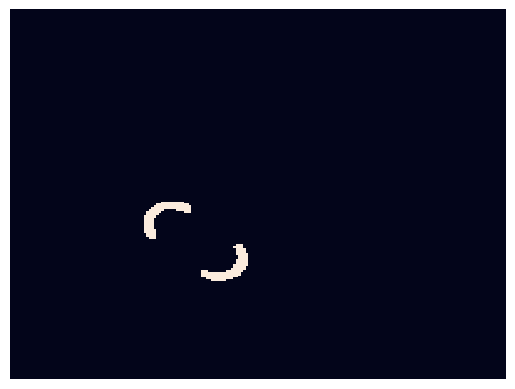

In [61]:
task_name = "two_moons"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

sims = 10_000 # same number for both test and calibration
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

thetas = get_thetas_grid(-1, 1)
test_sim = 1
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]
test_x_tiled = np.tile(test_x, (thetas.shape[0], 1)).astype(np.float32)

device = "cpu"
cached_fn = f"{task_name}.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
desired_coverages = [0.75, 0.85, 0.95]
desired_coverage = desired_coverages[-1]
    
probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
probs_map = probs.reshape((200, 200))

conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
sns.heatmap((1 / probs_map) < conformal_quantile, cbar=False, xticklabels=False, yticklabels=False)

In [69]:
from scipy.ndimage.measurements import label
from sklearn.cluster import KMeans

region = ((1 / probs_map) < conformal_quantile).astype(int)
structure = np.ones((3, 3), dtype=int)  # this defines the connection filter
labeled, ncomponents = label(region, structure)

N = 4
total_covered = np.sum(region)
total_rps = 0
rps = []

for component in range(1, ncomponents + 1):
    component_prop = np.sum(labeled == component) / total_covered
    if component == ncomponents:
        n = N - total_rps
    else:
        n = int(np.round(component_prop * N))
        total_rps += n

    location_pairs = np.where(labeled == component)
    locations = list(zip(location_pairs[0], location_pairs[1]))
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(locations)
    rps.append(kmeans.cluster_centers_)

/tmp/ipykernel_3119246/369991374.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


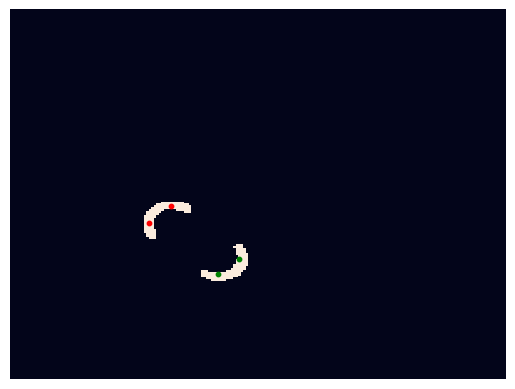

In [70]:
sns.heatmap((1 / probs_map) < conformal_quantile, cbar=False, xticklabels=False, yticklabels=False)

colors = ["red", "green", "yellow", "blue"]
for cluster_idx, rp in enumerate(rps):
    plt.scatter(rp[:,1], rp[:,0], s=10, color=colors[cluster_idx])

In [82]:
N = 4  # number of representation points
T = 500_000 # time steps of repulsive simulation

y_hat = encoder.sample(N, test_x)[0].detach().cpu().numpy()
test_x_tiled = np.tile(test_x, (y_hat.shape[0], 1)).astype(np.float32)
trajectory = []
eta = 0.01

for _ in range(T):
    proposed_y_hat = y_hat + eta * np.random.randn(y_hat.shape[0], y_hat.shape[1]).astype(np.float32)
    proposed_probs = encoder.log_prob(proposed_y_hat, test_x_tiled).detach().cpu().exp().numpy()

    in_region = (1 / proposed_probs) < conformal_quantile
    y_hat[in_region] = proposed_y_hat[in_region]
    trajectory.append(y_hat.copy())
trajectory = np.array(trajectory)

KeyboardInterrupt: 

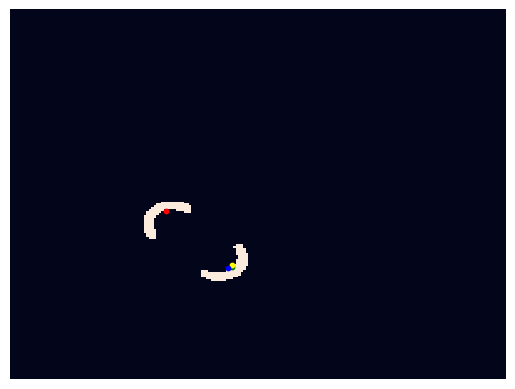

In [121]:
rps = []
trajectory = np.array(trajectory)
for n in range(N):
    subtraj = trajectory[:,n,:]
    kmeans = KMeans(n_clusters=1, random_state=0, n_init="auto").fit(subtraj)
    rps.append(kmeans.cluster_centers_)
rps = np.array(rps)

sns.heatmap((1 / probs_map) < conformal_quantile, cbar=False, xticklabels=False, yticklabels=False)
for cluster_idx, rp in enumerate(rps):
    plt.scatter((rps[cluster_idx,:,0] + 1) * 100, (rps[cluster_idx,:,1] + 1) * 100, s=10, color=colors[cluster_idx])

In [120]:
from scipy import stats
stats.kstest(trajectory[:,3,0], trajectory[:,2,0])

KstestResult(statistic=0.14783941158443153, pvalue=4.237356009999109e-156)